# **Bayesian regression**

    Notebook version: 1.2 (Oct 06, 2015)

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version
             v.1.1 - ML Model selection included
             v.1.2 - Some typos corrected
    
    Pending changes: * Include regression on the stock data

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab

# 3. Bayesian regression

In the previous session we tackled the problem of fitting the following model using the LS criterion:

$${\hat s}({\bf x}) = f({\bf x}) = {\bf w}^\top {\bf z}$$

where ${\bf z}$ is a vector with components which can be computed directly from the observed variables. Such expression includes a linear regression model, where ${\bf z} = [1; {\bf x}]$, as well as any other non-linear model as long as it can be expressed as a <i>"linear in the parameters"</i> model.

The LS solution was defined as the one minimizing the square of the residuals over the training set $\{{\bf x}^{(k)}, s^{(k)}\}_{k=1}^K$. As a result, a single parameter vector ${\bf w}_{LS}$ was obtained, and correspondingly a single regression curve.

In this session, rather than trying to obtain the best single model, we will work with a family of models or functions, and model the problem probabilistically, so that we can assign a probability value to each of the possible functions.

## 3.1 Maximum Likelihood estimation of the weights

### 3.1.1 Limitations of the LS approach. The need for assumptions

Consider the same regression task of the previous session. We have a training dataset consisting of 15 points which are given, and depict the regression curves that would be obtained if adding an additional point at a fixed location, depending on the target value of that point:

(You can run this code fragment several times, to check also the changes in the regression curves between executions, and depending also on the location of the training points)

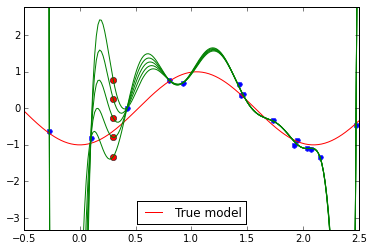

In [2]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
n_val_16 = 5
degree = 12

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-.5,2.5,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

X_16 = .3 * np.ones((n_val_16,))
S_16 = np.linspace(np.min(S_tr),np.max(S_tr),n_val_16)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)
ax.plot(X_16,S_16,'ro',markersize=6)
ax.plot(X_grid,S_grid,'r-',label='True model')

for el in zip(X_16,S_16):
    #Add point to the training set
    X_tr_iter = np.append(X_tr,el[0])
    S_tr_iter = np.append(S_tr,el[1])
    
    #Obtain LS regression coefficients and evaluate it at X_grid
    w_LS = np.polyfit(X_tr_iter, S_tr_iter, degree)
    S_grid_iter = np.polyval(w_LS,X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

ax.set_xlim(-.5,2.5)
ax.set_ylim(S_16[0]-2,S_16[-1]+2)
ax.legend(loc='best')

   - You can modify the degree of the polynomia, and check that when the degree is set to 15 (16 weights) all points will be fitted perfectly
   - It seems obvious that we have not solved the problem ... 
        * The regression curves overfit the training data
        * The regression curves change a lot when varying the label of just one pattern

The key missing ingredient is assumptions !!

### Open questions

   - Do we think that all models are equally probable... before we see any data? What does the term <i>model probability</i> mean?
   
   - Do we need to choose a single "best" model or can we consider several of them simultaneously?
   
   - Perhaps our training targets are contaminated with noise. What to do?
   
We will start postulating a <i>generative model</i> for the training data that includes the presence of noise contaminating the targets, and work on this model to partly answer the other two questions.

### 3.1.2 Generative model

Denoting by $f({\bf x}) = {{\bf w}}^\top {\bf z}$ the true function that we would like to obtain, we could assume that the observations in the training set are obtained as noisy values of the output of such function, i.e.,

$$s^{(k)} = f({\bf x}^{(k)}) + \varepsilon^{(k)}$$

We will further characterize the noise values as i.i.d. and normally distributed, with mean zero, and variance $\sigma_\varepsilon^2$, i.e.,

$$\varepsilon \sim {\cal N}\left(0, \sigma_\varepsilon^2\right)$$

### 3.1.3 The maximum likelihood solution

   - Joint distribution of the noise samples, ${\pmb \varepsilon} = \left[\varepsilon^{(1)}, \dots, \varepsilon^{(K)}\right]^\top$:
   
   $${\pmb \varepsilon} \sim \left( {\bf 0}, \sigma_{\varepsilon}^2 {\bf I}\right) \;\;\; p({\pmb \varepsilon}) = \left(\frac{1}{\sqrt{2\pi \sigma_{\varepsilon}^2}}\right)^K \exp\left(- \frac{{\pmb \varepsilon}^\top {\pmb \varepsilon}}{2 \sigma_{\varepsilon}^2}\right)$$
   
  
   - Denoting ${\bf s} = \left[s^{(1)}, \dots, s^{(K)} \right]^\top$ and ${\bf f} = \left[ f({\bf x}^{(1)}), \dots,f({\bf x}^{(K)})\right]^\top$, we have
   
   $${\bf s} = {\bf f} + {\pmb \varepsilon}$$
   
   - Conditioning on the values of the target function, ${\bf f}$, the pdf of the available targets is obtained as a shifted version of the distribution of the noise. More precisely:
   
   \begin{align}p({\bf s}|{\bf f}) & = \left(\frac{1}{\sqrt{2\pi \sigma_{\varepsilon}^2}}\right)^K \exp\left(- \frac{\|{\bf s} - {\bf f}\|^2}{2 \sigma_{\varepsilon}^2}\right) \end{align}
   
   
   - For the particular parametric selection of $f({\bf x})$, ${\bf f} = {\bf Z} {\bf w}$, conditioning on ${\bf f}$ is equivalent to conditioning on ${\bf w}$, so that:
   
   $$p({\bf s}|{\bf f}) = p({\bf s}|{\bf w}) = \left(\frac{1}{\sqrt{2\pi \sigma_{\varepsilon}^2}}\right)^K \exp\left(- \frac{\|{\bf s} - {\bf Z}{\bf w}\|^2}{2 \sigma_{\varepsilon}^2}\right)$$
   
   
   - The previous expression represents the probability of the observed targets given the weights, and is also known as the likelihood of the weights for a particular training set.
   
   
The <b>maximum likelihood</b> solution is then given by:

$${\bf w}_{ML} = \arg \max_{\bf w} p({\bf s}|{\bf w}) = \arg \min_{\bf w} \|{\bf s} - {\bf Z}{\bf w}\|^2$$


### 3.1.4 Multiple explanations of the data

With an additive Gaussian independent noise model, the maximum likelihood and the least squares solutions are the same. We have not improved much ...

However, we have already formulated the problem in a probabilistic way. This opens the door to reasoning in terms of a set of possible explanations, not just one. We believe more than one of our models could have generated the data.

   - We do not believe all models are equally likely to have generated the data
   - We may <b>believe</b> that a simpler model is more likely than a complex one

## 3.2 Bayesian Inference

### 3.2.1 Posterior distribution of weights

If we express our <i>a priori</i> belief of models using a prior distribution $p({\bf w})$, then we can infer the <i>a posteriori</i> distribution using Bayes' rule:
   
   $$p({\bf w}|{\bf s}) = \frac{p({\bf s}|{\bf w})~p({\bf w})}{p({\bf s})}$$
   
   Where:
   - $p({\bf s}|{\bf w})$: is the likelihood function
   - $p({\bf w})$: is the <i>prior</i> distribution of the weights (assumptions are needed here)
   - $p({\bf s})$: is the <i>marginal</i> distribution of the observed data, which could be obtained integrating the expression in the numerator
   

The previous expression can be interpreted in a rather intuitive way:

   - Since ${\bf w}$ are the parameters of the model, $p({\bf w})$ express our belief about which models should be preferred over others before we see any data. For instance, since parameter vectors with small norms produce smoother curves, we could assign (<i>a priori</i>) a larger pdf value to models with smaller norms
   
   - The likelihood function $p({\bf s}|{\bf w})$ tells us how well the observations can be explained by a particular model
   
   - Finally, the posterior distribution $p({\bf w}|{\bf s})$ expresses the estimated goodness of each model (i.e., each parameter vector ${\bf w}$) taking into consideration both the prior and the likelihood of $\bf w$. Thus, a model with large $p({\bf w})$ would have a low posterior value if it offers a poor explanation of the data (i.e., if $p({\bf s}|{\bf w})$ is small), whereas models that fit well with the observations would get emphasized
   
The posterior distribution of weights opens the door to working with several models at once. Rather thank keeping the estimated best model according to a certain criterion, we can now use all models parameterized by ${\bf w}$, assigning them different degrees of confidence according to $p({\bf w}|{\bf s})$.

### 3.2.2 Maximum likelihood vs Bayesian Inference.  Making predictions

   - Following an <b>ML approach</b>, we retain a single model, ${\bf w}_{ML} = \arg \max_{\bf w} p({\bf s}|{\bf w})$. Then, the predictive distribution of the target value for a new point would be obtained as:
   
   $$p({s^*}|{\bf w}_{ML},{\bf x}^*) $$
   
   For the generative model of Section 3.1.2 (additive i.i.d. Gaussian noise), this distribution is:
   
   $$p({s^*}|{\bf w}_{ML},{\bf x}^*) = \frac{1}{\sqrt{2\pi\sigma_\varepsilon^2}} \exp \left(-\frac{\left(s^* - {\bf w}_{ML}^\top {\bf z}^*\right)^2}{2 \sigma_\varepsilon^2} \right)$$
   
      * The mean of $s^*$ is just the same as the prediction of the LS model, and the same uncertainty is assumed independently of the observation vector (i.e., the variance of the noise of the model).
      
      * If a single value is to be kept, we would probably keep the mean of the distribution, which is equivalent to the LS prediction.
   
   
   - Using <b>Bayesian inference</b>, we retain all models. Then, the inference of the value $s^* = s({\bf x}^*)$ is carried out by mixing all models, according to the weights given by the posterior distribution.
   
   \begin{align}p({s^*}|{\bf x}^*,{\bf s}) & = \int p({s^*},{\bf w}~|~{\bf x}^*,{\bf s}) d{\bf w} \\
                         & = \int p({s^*}~|~{\bf w},{\bf x}^*,{\bf s}) p({\bf w}~|~{\bf x}^*,{\bf s}) d{\bf w} \\
                         & = \int p({s^*}~|~{\bf w},{\bf x}^*) p({\bf w}~|~{\bf s}) d{\bf w}\end{align}
   
   where:
   
      * $p({s^*}|{\bf w},{\bf x}^*) = \displaystyle\frac{1}{\sqrt{2\pi\sigma_\varepsilon^2}} \exp \left(-\frac{\left(s^* - {\bf w}^\top {\bf z}^*\right)^2}{2 \sigma_\varepsilon^2} \right)$
      * $p({\bf w}~|~{\bf s})$: Is the posterior distribution of the weights, that can be computed using Bayes' Theorem.

### 3.2.3 Example: Selecting a Gaussian prior for the weights

#### Prior distribution of the weights

In this section, we consider a particular example in which we assume the following prior for the weights:

$${\bf w} \sim {\cal N}\left({\bf 0},{\pmb \Sigma}_{p} \right)$$

Since the Gaussian distribution is larger around its mean, this prior distribution assigns more credibility to models with smaller $\|{\bf w}\|$, i.e., to models that produce smoother curves $f({\bf x}) = {\bf w}^\top {\bf z}$.

The following figure shows functions which are generated by drawing models from this distribution. You can check that faster oscillating regression curves can be obtained if the width of the Gaussian prior for $\bf w$ increases.

(-3.3238702668658351, 2.7843168427137757)

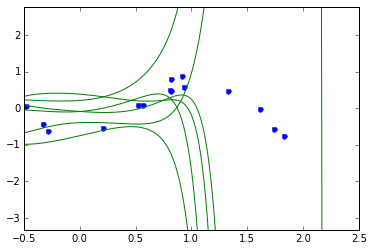

In [3]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 12
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_w = 0.3  ### Try increasing this value
var_w = sigma_w * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-.5,2.5,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

for k in range(nplots):
    
    #Draw weigths fromt the prior distribution
    w_iter = np.random.multivariate_normal(mean_w,var_w)
    S_grid_iter = np.polyval(w_iter,X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

ax.set_xlim(-.5,2.5)
ax.set_ylim(S_16[0]-2,S_16[-1]+2)


#### Likelihood of the weights

According to the generative model, ${\bf s} = {\bf Z}{\bf w} + {\pmb \varepsilon}$

$${\bf s}~|~{\bf w} \sim {\cal N}\left({\bf Z}{\bf w},\sigma_\varepsilon^2 {\bf I} \right)$$

#### Posterior distribution of the weights

$$p({\bf w}|{\bf s}) = \frac{p({\bf s}|{\bf w})~p({\bf w})}{p({\bf s})}$$

Since both $p({\bf s}|{\bf w})$ and $p({\bf w})$ follow a Gaussian distribution, we know also that the joint distribution and the posterior distribution of ${\bf w}$ given ${\bf s}$ are also Gaussian. Therefore,

$${\bf w}~|~{\bf s} \sim {\cal N}\left({\bar{\bf w}} , {\pmb\Sigma}_{\bf w}\right)$$

where the mean and the covariance matrix of the distribution are to be determined.

<b>Exercise:</b>

Show that the posterior mean and posterior covariance matrix of ${\bf w}$ given ${\bf s}$ are:


$${\pmb\Sigma}_{\bf w} = \left[\frac{1}{\sigma_\varepsilon^2} {\bf Z}^{\top}{\bf Z} + {\pmb \Sigma}_p^{-1}\right]^{-1}$$


$${\bar{\bf w}} = {\sigma_\varepsilon^{-2}} {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}$$

The following fragment of code draws random vectors from $p({\bf w}|{\bf s})$, and plots the corresponding regression curves along with the training points. Compare these curves with those extracted from the prior distribution of ${\bf w}$ and with the LS solution.

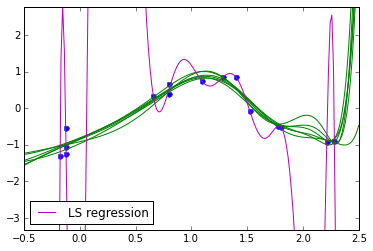

In [4]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 12
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .3 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-.5,2.5,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

for k in range(nplots):
    
    #Draw weights from the posterior distribution
    w_iter = np.random.multivariate_normal(posterior_mean,Sigma_w)
    #Note that polyval assumes the first element of weight vector is the coefficient of
    #the highest degree term. Thus, we need to reverse w_iter
    S_grid_iter = np.polyval(w_iter[::-1],X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-.5,2.5)
ax.set_ylim(S_16[0]-2,S_16[-1]+2)
ax.legend(loc='best')

#### Posterior distribution of the target 

   - Since $f^* = f({\bf x}^*) = {\bf w}^\top{\bf z}$, $f^*$ is also a Gaussian variable whose posterior mean and variance can be calculated as follows:
   
   $$\mathbb{E}\{{{\bf z}^*}^\top {\bf w}~|~{\bf s}, {\bf z}^*\} = {{\bf z}^*}^\top \mathbb{E}\{{\bf w}|{\bf s}\} = {\sigma_\varepsilon^{-2}} {{\bf z}^*}^\top  {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}$$
   
   $$\text{Cov}\left[{{\bf z}^*}^\top {\bf w}~|~{\bf s}, {\bf z}^*\right] = {{\bf z}^*}^\top \text{Cov}\left[{\bf w}~|~{\bf s}\right] {{\bf z}^*} = {{\bf z}^*}^\top {\pmb \Sigma}_{\bf w} {{\bf z}^*}$$
   
   
   - Therefore, $f^*~|~{\bf s}, {\bf x}^* \sim {\cal N}\left({\sigma_\varepsilon^{-2}} {{\bf z}^*}^\top  {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}, {{\bf z}^*}^\top {\pmb \Sigma}_{\bf w} {{\bf z}^*} \right)$
   
   - Finally, for $s^* = f^* + \varepsilon^*$, the posterior distribution is  $s^*~|~{\bf s}, {\bf z}^* \sim {\cal N}\left({\sigma_\varepsilon^{-2}} {{\bf z}^*}^\top  {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}, {{\bf z}^*}^\top {\pmb \Sigma}_{\bf w} {{\bf z}^*} + \sigma_\varepsilon^2\right)$

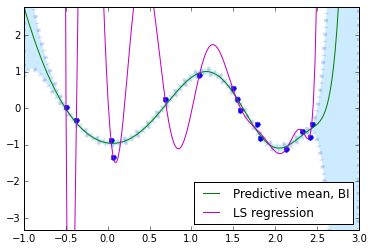

In [6]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 12
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .5 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-1,3,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

#Plot the posterior mean
#Note that polyval assumes the first element of weight vector is the coefficient of
#the highest degree term. Thus, we need to reverse w_iter
S_grid_iter = np.polyval(posterior_mean[::-1],X_grid)
ax.plot(X_grid,S_grid_iter,'g-',label='Predictive mean, BI')

#Plot confidence intervals for the Bayesian Inference
std_x = []
for el in X_grid:
    x_ast = np.array([el**k for k in range(degree+1)])
    std_x.append(np.sqrt(x_ast.dot(Sigma_w).dot(x_ast)[0,0]))
std_x = np.array(std_x)
plt.fill_between(X_grid, S_grid_iter-std_x, S_grid_iter+std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-1,3)
ax.set_ylim(S_16[0]-2,S_16[-1]+2)
ax.legend(loc='best')

Not only do we obtain a better predictive model, but we also have confidence intervals (error bars) for the predictions.

## 3.3 Maximum evidence model selection

We have already addressed with Bayesian Inference the following two issues:

   - For a given degree, how do we choose the weights?
   
   - Should we focus on just one model, or can we use several models at once?
   
However, we still needed some assumptions: a parametric model (i.e., polynomial function and <i>a priori</i> degree selection) and several parameters needed to be adjusted.

Though we can recur to cross-validation, Bayesian inference opens the door to other strategies. 

   - We could argue that rather than keeping single selections of these parameters, we could use simultaneously several sets of parameters (and/or several parametric forms), and average them in a probabilistic way ... (like we did with the models)
   
   - We will follow a simpler strategy, selecting just the most likely set of parameters according to an ML criterion

### 3.3.1 Model evidence

The evidence of a model is defined as

$$L = p({\bf s}~|~{\cal M})$$

where ${\cal M}$ denotes the model itself and any free parameters it may have. For instance, for the polynomial model we have assumed so far, ${\cal M}$ would represent the degree of the polynomia, the variance of the additive noise, and the <i>a priori</i> covariance matrix of the weights

Applying the Theorem of Total probability, we can compute the evidence of the model as

$$L = \int p({\bf s}~|~{\bf f},{\cal M}) p({\bf f}~|~{\cal M}) d{\bf f} $$

For the linear model $f({\bf x}) = {\bf w}^\top{\bf z}$, the evidence can be computed as

$$L = \int p({\bf s}~|~{\bf w},{\cal M}) p({\bf w}~|~{\cal M}) d{\bf w} $$

It is important to notice that these probability density functions are exactly the ones we computed on the previous section. We are just making explicit that they depend on a particular model and the selection of its parameters. Therefore:

   - $p({\bf s}~|~{\bf w},{\cal M})$ is the likelihood of ${\bf w}$
   
   - $p({\bf w}~|~{\cal M})$ is the <i>a priori</i> distribution of the weights

## 3.3.2 Model selection via evidence maximization

   - As we have already mentioned, we could propose a prior distribution for the model parameters, $p({\cal M})$, and use it to infer the posterior. However, this can be very involved (usually no closed-form expressions can be derived)
   
   - Alternatively, maximizing the evidence is normally good enough
   
   $${\cal M}_{ML} = \arg\max_{\cal M} p(s~|~{\cal M})$$
   
Note that we are using the subscript 'ML' because the evidence can also be referred to as the likelihood of the model

### 3.3.3 Example: Selection of the degree of the polynomia

For the previous example we had (we consider a spherical Gaussian for the weights):

   - ${\bf s}~|~{\bf w},{\cal M}~\sim~{\cal N}\left({\bf Z}{\bf w},\sigma_\varepsilon^2 {\bf I} \right)$
   
   - ${\bf w}~|~{\cal M}~\sim~{\cal N}\left({\bf 0},\sigma_p^2 {\bf I} \right)$
   
In this case, $p({\bf s}~|~{\cal M})$ follows also a Gaussian distribution, and it can be shown that

   - $L = p({\bf s}~|~{\cal M}) = {\cal N}\left({\bf 0},\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I} \right)$
   
If we just pursue the maximization of $L$, this is equivalent to maximizing the log of the evidence

$$\log(L) = -\frac{M}{2} \log(2\pi) -{\frac{1}{2}}\log\mid\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\mid - \frac{1}{2} {\bf s}^\top \left(\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\right)^{-1} {\bf s}$$

where $M$ denotes the length of vector ${\bf z}$ (the degree of the polynomia minus 1).
   
The following fragment of code evaluates the evidence of the model as a function of the degree of the polynomia

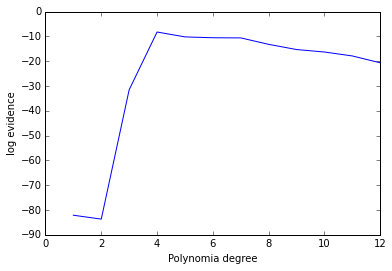

In [9]:
from math import pi

n_points = 15
frec = 3
std_n = 0.2
max_degree = 12

#Prior distribution parameters
sigma_eps = 0.2
mean_w = np.zeros((degree+1,))
sigma_p = 0.5

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Evaluate the posterior evidence

logE = []
for deg in range(max_degree):
    Z_iter = Z[:,:deg+1]
    logE_iter = -((deg+1)*np.log(2*pi)/2) \
                -np.log(np.linalg.det((sigma_p**2)*Z_iter.dot(Z_iter.T) + (sigma_eps**2)*np.eye(n_points)))/2 \
                -S_tr.T.dot(np.linalg.inv((sigma_p**2)*Z_iter.dot(Z_iter.T) + (sigma_eps**2)*np.eye(n_points))).dot(S_tr)/2
    logE.append(logE_iter[0,0])

plt.plot(np.array(range(max_degree))+1,logE)
plt.xlabel('Polynomia degree')
plt.ylabel('log evidence')


The above curve may change the position of its maximum from run to run.

We conclude the notebook by plotting the result of the Bayesian inference for M=6

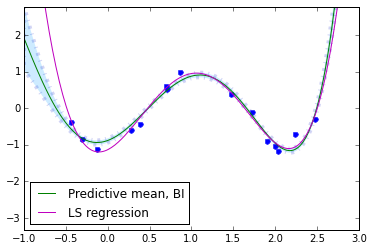

In [20]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 5 #M-1
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .5 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-1,3,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

#Plot the posterior mean
#Note that polyval assumes the first element of weight vector is the coefficient of
#the highest degree term. Thus, we need to reverse w_iter
S_grid_iter = np.polyval(posterior_mean[::-1],X_grid)
ax.plot(X_grid,S_grid_iter,'g-',label='Predictive mean, BI')

#Plot confidence intervals for the Bayesian Inference
std_x = []
for el in X_grid:
    x_ast = np.array([el**k for k in range(degree+1)])
    std_x.append(np.sqrt(x_ast.dot(Sigma_w).dot(x_ast)[0,0]))
std_x = np.array(std_x)
plt.fill_between(X_grid, S_grid_iter-std_x, S_grid_iter+std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-1,3)
ax.set_ylim(S_16[0]-2,S_16[-1]+2)
ax.legend(loc='best')

We can check, that now the model also seems quite appropriate for LS regression, but keep in mind that selection of such parameter was itself carried out using Bayesian inference.